# Test Model

In [ ]:
import tensorflow as tf
import pandas as pd
import keras
import keras.optimizers as Kopt
from keras import Sequential
from keras.layers import Input
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling2D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Flatten, InputLayer
from keras.layers import Dropout
from keras.layers import Masking
from keras.models import Model

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from keras.applications.vgg16 import VGG16
from keras.models import Model

from sklearn.model_selection import train_test_split

import glob
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Data

In [ ]:
with open('/content/drive/MyDrive/Thesis/train_test_data_collage.npy', 'rb') as f:
    X_train = np.load(f)
    X_val = np.load(f)
    y_train = np.load(f)
    y_val = np.load(f)
    X_testing = np.load(f)
    y_testing = np.load(f)

In [ ]:
print("Number of training collages:", X_train.shape[0])
print("Size of each training collage:", X_train.shape[1:])

print("Number of validation collages:", X_val.shape[0])
print("Size of each validation collage:", X_val.shape[1:])

print("Number of testing collages:", X_testing.shape[0])
print("Size of each testing collage:", X_testing.shape[1:])

Number of training collages: 560
Size of each training collage: (222, 367, 3)
Number of validation collages: 281
Size of each validation collage: (222, 367, 3)
Number of testing collages: 99
Size of each testing collage: (222, 367, 3)


## Transfer Learning

In [ ]:
input_shape = X_train.shape[1:]

In [ ]:
vgg = VGG16(include_top=False, input_shape=input_shape)
output = vgg.layers[-1].output
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

58900480/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7ff1a33b9a50>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7ff192017790>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7ff192017ed0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7ff190658290>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7ff19065c9d0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7ff190665110>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7ff19065cc50>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7ff19066f290>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7ff1906718d0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7ff192045310>,block3_conv3,False


In [ ]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [ ]:
train_features_vgg = get_bottleneck_features(vgg_model, X_train)
validation_features_vgg = get_bottleneck_features(vgg_model, X_val)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (560, 6, 11, 512) 	Validation Bottleneck Features: (281, 6, 11, 512)


In [ ]:
input_shape = vgg_model.output_shape[1:]

model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(Flatten())
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
#model.compile(loss="mse", optimizer="Adam", metrics="mae")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 33792)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               17302016  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 17,565,698
Trainable params: 17,565,698
Non-trainable params: 0
__________________________________________

In [ ]:
# This function changes the labels from single digit (1 for defect, and 0 for defect-free)
# to double digit: (1,0) for defect and (0,1) for defect-free
def change_labels(labels):
  new_labels = np.zeros([len(labels),2])
  for i, label in enumerate(labels):
    if label == 1.0:
      new_labels[i] = np.array([1,0])
    elif label == 0.0:
      new_labels[i] = np.array([0,1])
  return new_labels

In [ ]:
y_train = change_labels(y_train)
y_val = change_labels(y_val)
y_testing = change_labels(y_testing)

ValueError: ignored

Epoch 1/50
112/112 [==============================] - 2s 12ms/step - loss: 10.0565 - accuracy: 0.8429 - val_loss: 2.5108 - val_accuracy: 0.9324
Epoch 2/50
112/112 [==============================] - 1s 10ms/step - loss: 1.8706 - accuracy: 0.9232 - val_loss: 0.6590 - val_accuracy: 0.9466
Epoch 3/50
112/112 [==============================] - 1s 9ms/step - loss: 0.6236 - accuracy: 0.9446 - val_loss: 0.5612 - val_accuracy: 0.9039
Epoch 4/50
112/112 [==============================] - 1s 11ms/step - loss: 0.3324 - accuracy: 0.9607 - val_loss: 0.5996 - val_accuracy: 0.9395
Epoch 5/50
112/112 [==============================] - 1s 11ms/step - loss: 0.2760 - accuracy: 0.9714 - val_loss: 0.4272 - val_accuracy: 0.9466
Epoch 6/50
112/112 [==============================] - 1s 11ms/step - loss: 0.3437 - accuracy: 0.9536 - val_loss: 0.7730 - val_accuracy: 0.9288
Epoch 7/50
112/112 [==============================] - 1s 10ms/step - loss: 0.2728 - accuracy: 0.9536 - val_loss: 0.8530 - val_accuracy: 0.8897

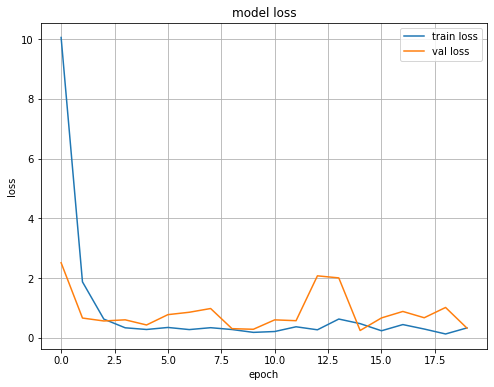

In [ ]:
# Define the early-stopping and performance scheduling callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0,
                                                  mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(train_features_vgg, y_train, 
                    validation_data=(validation_features_vgg, y_val), 
                    epochs=50, 
                    batch_size=5,
                    callbacks=[early_stopping_cb], 
                    shuffle=True, 
                    verbose=1)

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.grid(True)

In [ ]:
test_features_vgg = get_bottleneck_features(vgg_model, X_testing)

print('Test Bottleneck Features:', train_features_vgg.shape)

Test Bottleneck Features: (560, 6, 11, 512)


In [ ]:
y_pred = model.predict(test_features_vgg)
y_pred = np.round(y_pred)

In [ ]:
model.predict(test_features_vgg)

array([[1.7942203e-10, 1.0000000e+00],
       [1.3073815e-01, 8.6926186e-01],
       [1.0000000e+00, 0.0000000e+00],
       [1.3073815e-01, 8.6926186e-01],
       [1.0000000e+00, 0.0000000e+00],
       [5.0912838e-02, 9.4908708e-01],
       [1.0000000e+00, 0.0000000e+00],
       [1.3073815e-01, 8.6926186e-01],
       [1.0000000e+00, 0.0000000e+00],
       [2.4060790e-05, 9.9997592e-01],
       [1.0000000e+00, 2.4213492e-19],
       [1.0000000e+00, 2.6749836e-09],
       [2.2129530e-13, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.1400977e-17, 1.0000000e+00],
       [8.2020946e-03, 9.9179792e-01],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 7.0704288e-15],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 3.9932378e-21],
       [1.0807028e-12, 1.0000000e+00],
       [6.5784818e-08, 9.9999988e-01],
       [1.0000000e+00, 0.0000000e+00],
       [2.2561345e-07, 9.9999976e-01],
       [5.8412608e-10, 1.

In [ ]:
np.unique(y_pred[:,0], return_counts=True)

(array([0., 1.], dtype=float32), array([46, 53]))

In [ ]:
acc = accuracy_score(y_testing, y_pred)
f1 = f1_score(y_testing, y_pred, average='weighted')
print('Global accuracy:', acc)
print('Global f1 score:', f1)

Global accuracy: 0.9494949494949495
Global f1 score: 0.9495364448635476


In [ ]:
print('Predicted labels:', y_pred.T, 
      '\nActual labels:   ', y_testing.T)

Predicted labels: [[0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1.
  0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0.
  1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
  0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
  0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
  1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1.
  0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.
  1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
  1. 1. 1.]] 
Actual labels:    [[0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1.
  0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
  1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.
  0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
  0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 

In [ ]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
def make_gradcam_heatmap(
    img_array, classifier_model, last_conv_layer_model):

    # we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
img_index = 0
img = X_testing[img_index]
img_array = np.expand_dims(img, axis=0)

In [ ]:
with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = vgg_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

In [ ]:
  pred_index=None
  
  with tf.GradientTape() as tape:
        last_conv_layer_output = vgg_model(img_array)
        preds = model(last_conv_layer_output)
        if pred_index is None:
          pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        #class_channel = preds[0]

In [ ]:
pred_index

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [ ]:
class_channel

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [ ]:
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap

<tf.Tensor: shape=(6, 11), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
top_class_channel

In [ ]:
# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)
# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [ ]:
# convert both variables to numpy arrays
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()

In [ ]:
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

In [ ]:
heatmap

In [ ]:
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

In [ ]:
# This function creates a superimposed visualization of the resized (recoloured)
# heatmap onto the original image
def make_gradcam(img, heatmap, colour_map='rainbow'):    
        
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use a colormap to colorize heatmap
    colourmap = cm.get_cmap(colour_map)

    # We use RGB values of the colormap
    colourmap_colours = colourmap(np.arange(256))[:, :3]
    colourmap_heatmap = colourmap_colours[heatmap]

    # We create an image with RGB colorized heatmap
    colourmap_heatmap = keras.preprocessing.image.array_to_img(colourmap_heatmap)
    colourmap_heatmap = colourmap_heatmap.resize((img.shape[1], img.shape[0]))
    #colourmap_heatmap = cv2.resize(colourmap_heatmap, (img.shape[1], img.shape[0]))
    colourmap_heatmap = keras.preprocessing.image.img_to_array(colourmap_heatmap)

    # convert colourmap_heatmap to BGR colour scheme
    colourmap_heatmap = cv2.cvtColor(colourmap_heatmap, cv2.COLOR_RGB2BGR)

    # Superimpose the heatmap on grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_BGR = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    superimposed_img = colourmap_heatmap * 0.4 + gray_BGR

    # Display Grad CAM
    cv2_imshow(superimposed_img)

In [ ]:
# # this function returns the model prediction for a given image
# def get_prediction(img):
    
#     # expand dimensions for batch input to model
#     img_array = np.expand_dims(img, axis=0)

#     #get bottleneck features
#     features_vgg = vgg_model.predict(img_array)
       
#     # predict the probability across all output classes
#     yhat = model.predict(features_vgg)
#     # round the prediction to avoid errors
#     label = np.round(yhat)

#     if label == 1.0:
#       print('Prediction: "Defect"')

#     elif label == 0.0:
#       print('Prediction: "Defect-Free"')


In [ ]:
# this function returns the model prediction for a given image
def get_prediction(img_index):
    
  label = y_pred[img_index]

  if label == 1.0:
    print('Predicted Class: "Defect"')

  elif label == 0.0:
    print('Predicted Class: "Defect-Free"')

In [ ]:
# this function returns the actual class for a given image
def get_class(img_index):

  label = y_testing[img_index]

  if label == 1.0:
    print('Actual Class: "Defect"')

  elif label == 0.0:
    print('Actual Class: "Defect-Free"')

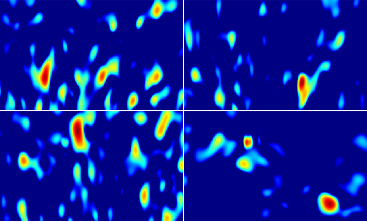

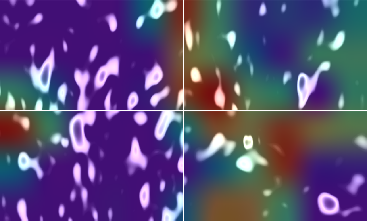

In [ ]:
img_index = 55

img = X_testing[img_index]
#get_prediction(img_index)
#get_class(img_index)
cv2_imshow(img)
print(' ')

img_array = np.expand_dims(img, axis=0)
heatmap = make_gradcam_heatmap(img_array, model, vgg_model)
make_gradcam(img=img, heatmap=heatmap)

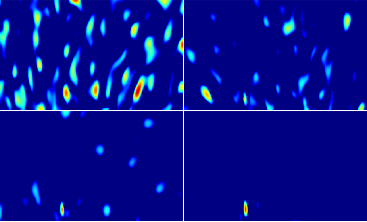

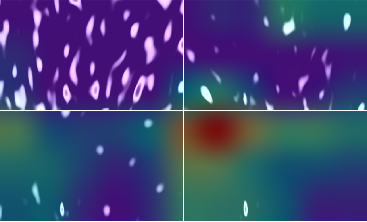

In [ ]:
img_index = 62

img = X_testing[img_index]
#get_prediction(img_index)
#get_class(img_index)
cv2_imshow(img)
print(' ')

img_array = np.expand_dims(img, axis=0)
heatmap = make_gradcam_heatmap(img_array, model, vgg_model)
make_gradcam(img=img, heatmap=heatmap)